# Random Forest

This note introduces the **Random Forest** algorithm using `scikit‑learn`, explains the step‑by‑step logic behind how it works, and then demonstrates a from‑scratch implementation to show that the core idea is simple and builds naturally on Decision Trees.

## What is a Random Forest?

A **Random Forest** is an ensemble of multiple **Decision Trees**, each trained on a slightly different version of the data.  
The final prediction is made by **aggregating** the predictions of all the trees — for classification, this is usually a **majority vote**.

Each tree is trained using:

- A **random subset of the training samples** (called bootstrap sampling)
- A **random subset of the features** at each split

This randomness ensures that the trees are diverse, which helps reduce **overfitting** and improves **generalization**.

> **Random Forest** was introduced by Leo Breiman in 2001 as an extension of his earlier work on **Bagging** and Decision Trees.

In this note, we focus on classification.

This notebook will:

- **Use `scikit‑learn`** to demonstrate how Random Forest works in practice  
- **Explain the logic behind it** in an intuitive way (bootstrap sampling, feature bagging, majority voting)  
- **Show how to implement the same idea step by step from scratch**, building on our Decision Tree code  

Let’s dive into the details to understand how it works and how to implement it ourselves.

## Preparation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import accuracy_score

# Load dataset
X, y = load_iris(return_X_y=True)

## Implement with Scikit-Learn

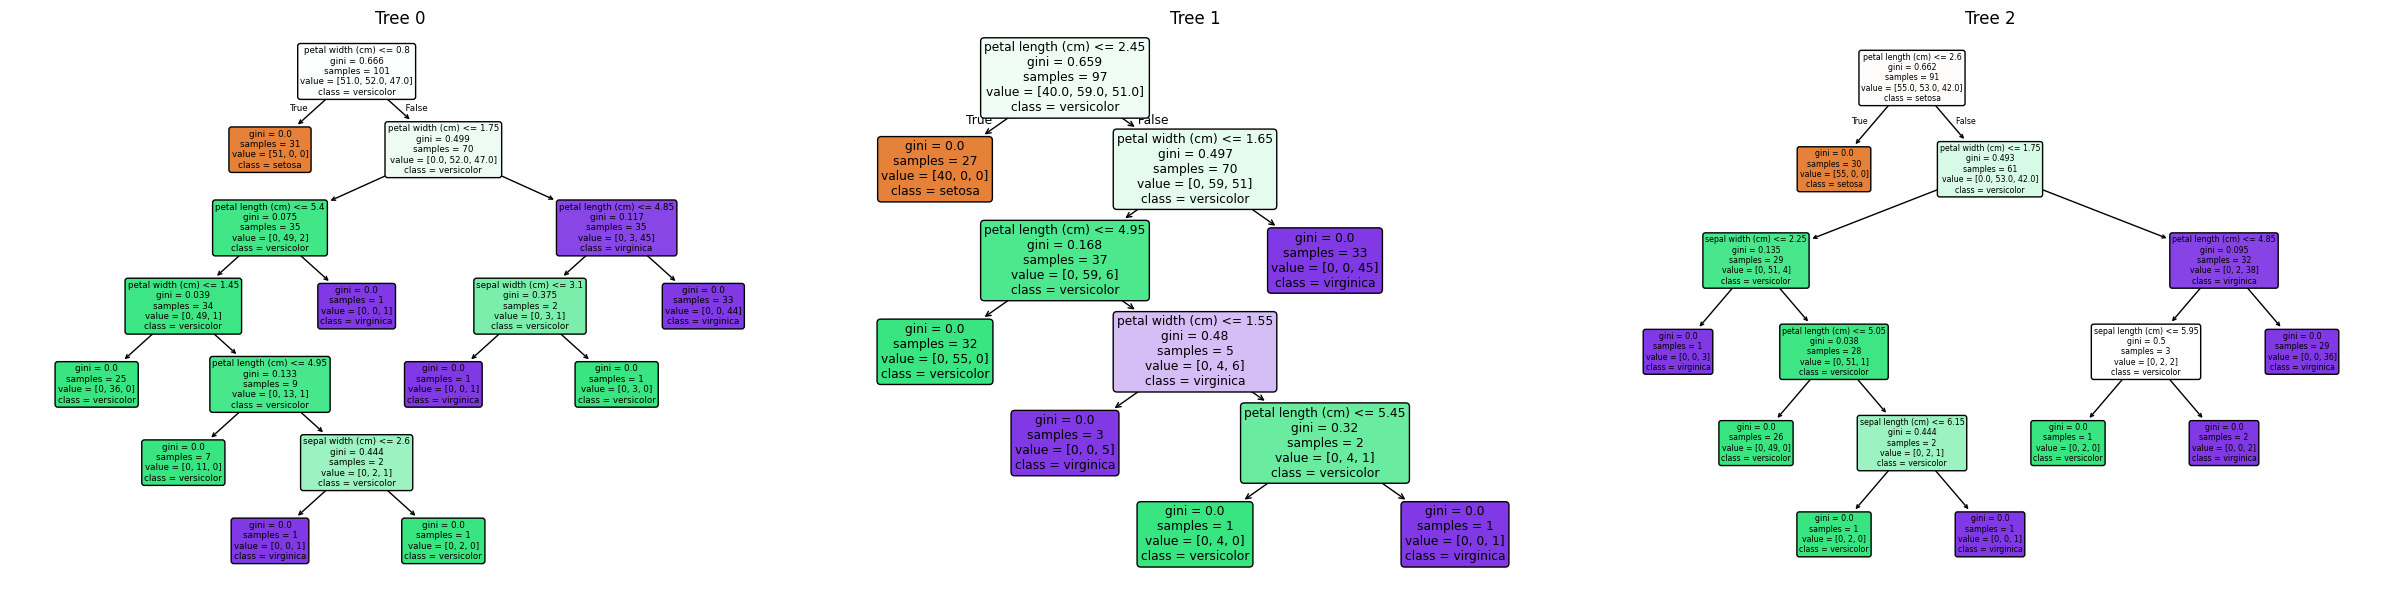

Tree 0 Accuracy = 0.9867
Tree 1 Accuracy = 0.9867
Tree 2 Accuracy = 0.9667
Random Forest Accuracy (Majority Vote) = 0.9933


In [ ]:
# Fit Random Forest with 3 trees
sk_model = RandomForestClassifier(
    n_estimators=3,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    bootstrap=True,
    random_state=42
)
sk_model.fit(X, y)

# Plot all 3 trees side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

for i, ax in enumerate(axes):
    plot_tree(
        sk_model.estimators_[i],
        feature_names=load_iris().feature_names,
        class_names=load_iris().target_names,
        filled=True, rounded=True,
        ax=ax
    )
    ax.set_title(f"Tree {i}")

plt.tight_layout()
plt.show()

for i, tree in enumerate(sk_model.estimators_):
    y_pred = tree.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"Tree {i} Accuracy = {acc:.4f}")

y_pred = sk_model.predict(X)
acc = accuracy_score(y, y_pred)
print(f"Random Forest Accuracy (Majority Vote) = {acc:.4f}")

## Understanding the Visualization

The diagram above shows **3 different trees** in a Random Forest.

Each tree:

- Was trained on a **different random subset of the training data** (via *bootstrap sampling*).
- Uses a **random subset of the features** when deciding each split.
- Produces its **own prediction**.

Together, they form a **committee** that votes on the final prediction.  
For classification tasks, the Random Forest selects the **majority vote** — the class label that most trees agree on.

> This voting process **improves accuracy** by reducing the impact of overfitting from any single tree.  

## Behind the Scenes

### 1. Bootstrap Sampling — Randomizing the Data

To create diversity, each tree in the forest is trained on a **bootstrapped** dataset.

- This means drawing **random samples *with replacement*** from the training set.
- As a result, each tree sees a slightly different dataset, which helps **reduce overfitting**.

Think of it as creating multiple “views” of the same reality.

### 2. Feature Bagging — Randomizing the Splits

To add more randomness:

- When splitting a node, a tree only considers a **random subset of the features** — not all features.
- This prevents all trees from picking the same dominant feature and makes the forest **less correlated**.

By varying both the **data** and the **features**, each tree becomes unique.

### 3. Majority Voting — Final Decision

Once all trees are trained:

- A new sample is passed through **every tree**.
- Each tree makes a **prediction**.
- The Random Forest combines their votes and picks the **most frequent class**.

This strategy is known as **majority voting**, and it helps **cancel out noisy decisions** from any single tree.

> 🧠 In short:  
> Random Forest = many **weak learners** (trees) trained differently + **simple voting** = strong, stable model.

## Let's Code It

We’ll build a **Random Forest from scratch**, but use `scikit-learn` to grow the individual Decision Trees.

This lets us focus on the core **Random Forest logic**:

- Bootstrap the training data
- Randomly select features for each tree
- Combine predictions using **majority vote**

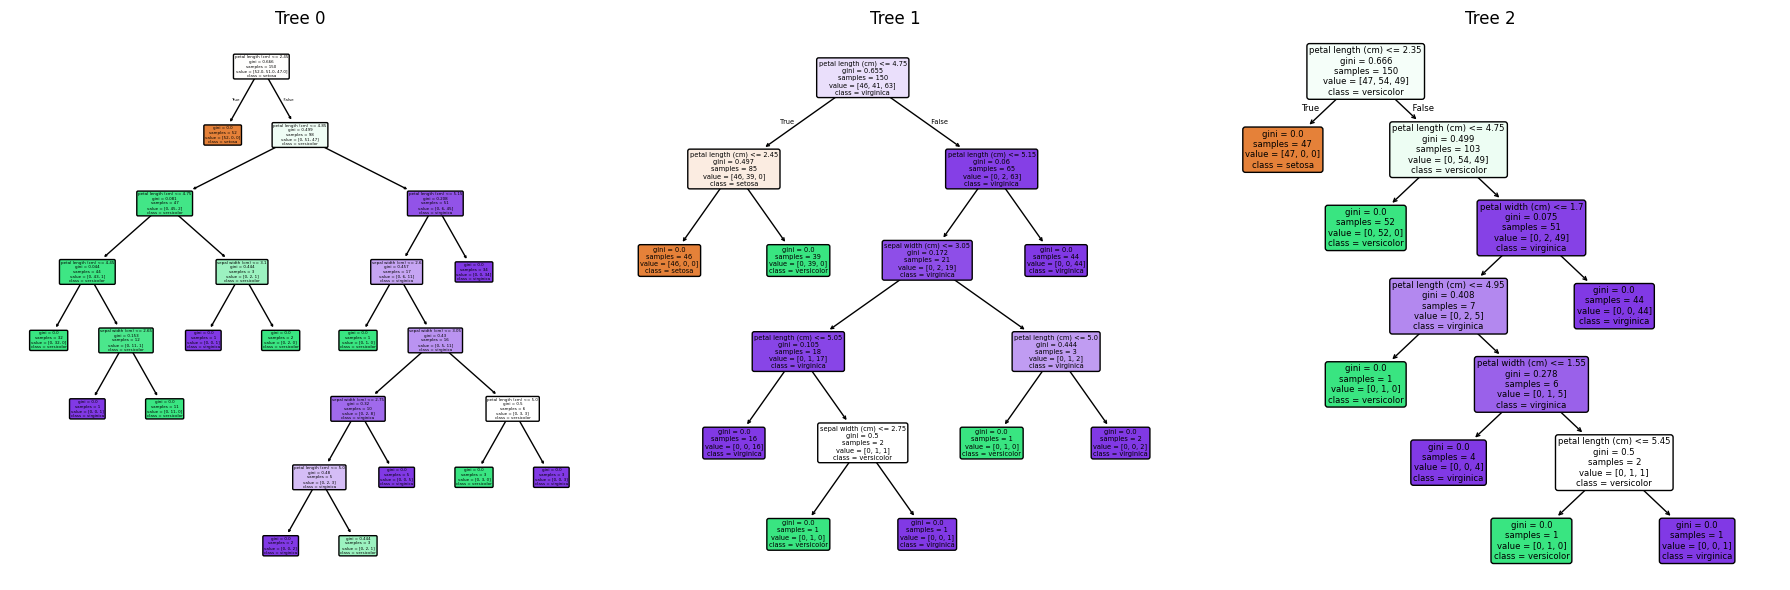

Tree 0 Accuracy = 0.9467
Tree 1 Accuracy = 0.9600
Tree 2 Accuracy = 0.9800
Random Forest Accuracy (Majority Vote) = 0.9667


In [ ]:
n_samples, n_features = X.shape
n_trees = 3
max_features = int(np.sqrt(n_features))  # commonly sqrt(d)
random_state = np.random.RandomState(42)

trees = []
feature_subsets = []

# --- Train Each Tree ---
for _ in range(n_trees):
    # --- 1. Bootstrap Sample (sample with replacement) ---
    indices = random_state.choice(n_samples, size=n_samples, replace=True)
    X_sample, y_sample = X[indices], y[indices]
    
    # --- 2. Random Feature Subset ---
    feature_indices = random_state.choice(n_features, size=max_features, replace=False)
    feature_subsets.append(feature_indices)
    
    # --- 3. Train Decision Tree on Sampled Data + Features ---
    tree = DecisionTreeClassifier()
    tree.fit(X_sample[:, feature_indices], y_sample)
    trees.append(tree)

# --- Predict by Majority Vote ---
def forest_predict(X):
    all_preds = []

    for tree, feat_idx in zip(trees, feature_subsets):
        preds = tree.predict(X[:, feat_idx])
        all_preds.append(preds)
    
    all_preds = np.array(all_preds).T  # shape: (n_samples, n_trees)

    # For each sample, get majority vote
    y_pred = []
    for row in all_preds:
        vote = Counter(row).most_common(1)[0][0]
        y_pred.append(vote)

    return np.array(y_pred)

# Number of trees to visualize
n_trees = len(trees)

# Set up subplots (1 row, n_trees columns)
fig, axes = plt.subplots(1, n_trees, figsize=(6 * n_trees, 6))

for i, ax in enumerate(axes):
    plot_tree(
        trees[i],
        feature_names=[load_iris().feature_names[j] for j in feature_subsets[i]],
        class_names=load_iris().target_names,
        filled=True,
        rounded=True,
        ax=ax
    )
    ax.set_title(f"Tree {i}")

plt.tight_layout()
plt.show()

# --- Accuracy for each tree individually ---
for i, (tree, feat_idx) in enumerate(zip(trees, feature_subsets)):
    y_pred_tree = tree.predict(X[:, feat_idx])
    acc_tree = accuracy_score(y, y_pred_tree)
    print(f"Tree {i} Accuracy = {acc_tree:.4f}")

# --- Accuracy for the full forest (majority vote) ---
y_pred_forest = forest_predict(X)
acc_forest = accuracy_score(y, y_pred_forest)
print(f"Random Forest Accuracy (Majority Vote) = {acc_forest:.4f}")

## It Works!!

We successfully built a **Random Forest** from scratch using `scikit-learn` Decision Trees.

- Each of the **3 trees** was trained on a different random subset of data and features.
- Individually, their predictions vary — but when combined via **majority voting**, the forest becomes more accurate and stable.

> This confirms that our logic — bootstrap sampling, random feature selection, and aggregating predictions — behaves exactly as expected.

We've successfully built a simple yet effective **Random Forest Classifier** from the ground up!